In [170]:
import pandas as pd

In [171]:
colors = ['#28abaf','#66ccff','#EE0000','#006666','#FFFF00','#0080FF']
import matplotlib.pyplot as plt
p = '/home/kent/fonts/Roboto_Condensed/static'
import os
all_font_flie_names = os.listdir(p)
all_ttf_file_names = [n for n in all_font_flie_names if n.endswith('.ttf')]
from matplotlib.font_manager import fontManager
for ttf_file_name in all_ttf_file_names:
    fontManager.addfont(path=os.path.join(p,ttf_file_name))


import matplotlib.pyplot as plt
plt.rcParams['font.family'] = ['sans-serif'] 
plt.rcParams['font.sans-serif'] = ['Roboto Condensed'] 
plt.rcParams['font.size'] = 13

In [172]:
from config import IDEA_MODELS, CRITIC_MODELS

In [173]:
def clean_model_name(name):
    # 处理路径，去掉"/"前面的部分
    if '/' in name:
        name = name.split('/', 1)[1]  # 只拆分一次，取第二部分
    
    # 处理特定的后缀
    if ':' in name:
        base_name, suffix = name.split(':', 1)
        # 只有当后缀是特定类型时才去掉
        if suffix in ['Q4_K_M', 'free']:
            return base_name
        # 否则保留完整名称，包括冒号和后缀
        return name
    
    return name


In [174]:
df = pd.read_csv('./csvs/view.csv',index_col=0)
df

,id,timestamp,keywords,idea_model,critic_model,idea,raw_critique,parsed_scores,parsed_reasoning,critique_reasoning,error,full_response,first_was_rejected,first_reject_response
0,287697,2025-03-24T03:25:54.772261,ecodesign,qwen/qwq-32b,openai/o3-mini-high,**Idea:** **Problem:** Current ecodesign relie...,The idea is innovative in embedding sustainabi...,"{'originality': 8, 'feasibility': 6, 'clarity'...",NaN,NaN,NaN,"Okay, I need to come up with a good scientific...",0,NaN
1,287696,2025-03-24T03:25:47.815311,ecodesign,qwen/qwq-32b,anthropic/claude-3.7-sonnet:thinking,**Idea:** **Problem:** Current ecodesign relie...,The AI-CAD plug-in concept addresses a signifi...,"{'originality': 7, 'feasibility': 6, 'clarity'...",NaN,Let me evaluate this AI-CAD plug-in idea for r...,NaN,"Okay, I need to come up with a good scientific...",0,NaN
2,287695,2025-03-24T03:25:30.569689,ecodesign,qwen/qwq-32b,openai/gpt-4.5-preview,**Idea:** **Problem:** Current ecodesign relie...,The proposed idea addresses a significant unme...,"{'originality': 9, 'feasibility': 6, 'clarity'...",NaN,NaN,NaN,"Okay, I need to come up with a good scientific...",0,NaN
3,287694,2025-03-24T03:24:24.914336,civil engineering,qwen/qwq-32b,openai/o3-mini-high,**Background:** Aging civil infrastructure fac...,The idea offers an interesting integration of ...,"{'originality': 7, 'feasibility': 6, 'clarity'...",NaN,NaN,NaN,"Okay, the user wants me to come up with a ""Goo...",0,NaN
4,287693,2025-03-24T03:24:07.939114,civil engineering,qwen/qwq-32b,qwen/qwen-max,**Background:** Aging civil infrastructure fac...,**Analysis:** The idea of integrating self-hea...,"{'originality': 8, 'feasibility': 6, 'clarity'...",NaN,NaN,NaN,"Okay, the user wants me to come up with a ""Goo...",0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287692,5,2025-03-16T17:11:23.141098,neutron stars,openai/gpt-4o-mini,anthropic/claude-3.7-sonnet:thinking,"Neutron stars, the remnants of supernovae, are...",The idea proposes a dedicated gravitational wa...,"{'originality': 4, 'feasibility': 6, 'clarity'...",NaN,Let's break down this idea and evaluate it acr...,NaN,"Neutron stars, the remnants of supernovae, are...",0,NaN
287693,4,2025-03-16T17:11:02.954792,neutron stars,openai/gpt-4o-mini,openai/o3-mini-high,"Neutron stars, the remnants of supernovae, are...",The proposal is clearly articulated and effect...,"{'originality': 5, 'feasibility': 6, 'clarity'...",NaN,NaN,NaN,"Neutron stars, the remnants of supernovae, are...",0,NaN
287694,3,2025-03-16T17:10:49.223818,statistical thermodynamics,openai/gpt-4o-mini,openai/o3-mini-high,Statistical thermodynamics bridges macroscopic...,The proposal ingeniously blends statistical th...,"{'originality': 8, 'feasibility': 7, 'clarity'...",NaN,NaN,NaN,Statistical thermodynamics bridges macroscopic...,0,NaN
287695,2,2025-03-16T17:10:40.944491,statistical thermodynamics,openai/gpt-4o-mini,google/gemini-2.0-pro-exp-02-05:free,Statistical thermodynamics bridges macroscopic...,"This idea proposes using machine learning, gui...","{'originality': 7, 'feasibility': 5, 'clarity'...",NaN,NaN,NaN,Statistical thermodynamics bridges macroscopic...,0,NaN


In [175]:
# # del all rows with anthropic/claude-3-haiku
# df = df[df['idea_model'] != 'anthropic/claude-3-haiku']

In [176]:
# 看每一个idea_model的idea的平均长度，根据模型降序
df['idea_length_in_char'] = df['idea'].apply(lambda x: len(str(x)))
# 只有< 2500 char 的idea才是有效idea
df = df[df['idea_length_in_char'] < 2500]
# 只有 > 100 char 的idea才是有效idea
df = df[df['idea_length_in_char'] > 100]

df['idea_length_in_words'] = df['idea'].apply(lambda x: len(str(x).split()))
df['idea_length_in_words'].describe()




count   287095.0000
mean        88.3475
std         21.1448
min          1.0000
25%         77.0000
50%         89.0000
75%         98.0000
max        391.0000
Name: idea_length_in_words, dtype: float64

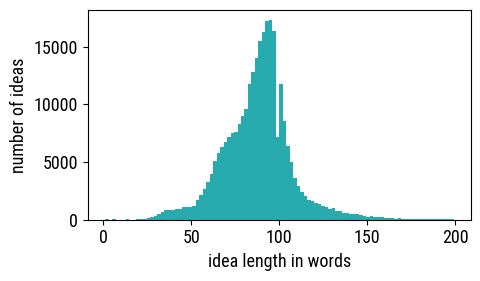

In [177]:
# 限制只有 < 200 words 的idea
df = df[df['idea_length_in_words'] < 200]
# 看直方图 
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
plt.hist(df['idea_length_in_words'], bins=100, color='#28abaf')
plt.xlabel('idea length in words')
plt.ylabel('number of ideas')
plt.tight_layout() # 添加这一行
plt.savefig('figs/idea_length_in_words.pdf')
plt.show()

In [178]:
# 统计有多少个独立的 keywords
n = df['keywords'].nunique()
print(n)

1182


In [179]:

# 看看有哪一个kw的哪一个模型没有进行测试
agg = df.groupby(['keywords', 'idea_model']).size()
print(agg)
# print(results_df.groupby(['kw', 'idea_model']).size())

last_run_index = agg.values.max()
print(last_run_index)
print('当前最大次数：', last_run_index)
# 获取当前最小次数
last_run_index = agg.values.min()
print(last_run_index)
print('当前最小次数（需要进行补充）：', last_run_index)

# 计数有多少个model是和最小次数的model是相同的
print(agg.values.min()) 
print(agg.values.min() == agg.values)
print(sum(agg.values.min() == agg.values))


keywords           idea_model                         
3d bioprinting     amazon/nova-lite-v1                    6
                   amazon/nova-pro-v1                     6
                   anthropic/claude-3-opus                6
                   anthropic/claude-3.5-haiku-20241022    6
                   anthropic/claude-3.5-sonnet            6
                                                         ..
zoonotic diseases  qwen/qwq-32b                           6
                   qwen/qwq-32b-preview                   6
                   sammcj/qwen2.5-dracarys2-72b:Q4_K_M    6
                   step-2-16k-202411                      6
                   x-ai/grok-2-1212                       6
Length: 48131, dtype: int64
9
当前最大次数： 9
1
当前最小次数（需要进行补充）： 1
1
[False False False ... False False False]
1


<Axes: ylabel='Count'>

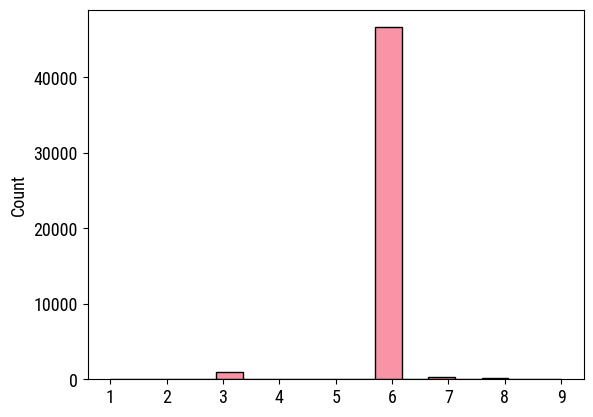

In [180]:
import seaborn as sns
sns.histplot(agg.values)

In [181]:
string = df['raw_critique'].tolist()
print(string[2])

The proposed idea addresses a significant unmet need by integrating real-time sustainability assessments directly into the product design phase, presenting an innovative approach that surpasses current retrospective methods. However, despite its strong originality, substantial challenges stand in the way of feasibility, such as real-time data integration complexity, accuracy of predictive models, and computational load within existing CAD frameworks. The proposal itself is clear, concise, and articulately presented, specifying exact tools and intended solution pathways. ```json { "originality": 9, "feasibility": 6, "clarity": 9 }```


In [182]:
score_dict = eval(df['parsed_scores'].iloc[0])
print(score_dict)
score_dict['originality']
score_dict['feasibility']
score_dict['clarity']

{'originality': 8, 'feasibility': 6, 'clarity': 8}


8

In [183]:
# 定义一个函数，如果eval出错返回None
def safe_eval(x):
    try:
        return eval(x)
    except:
        return None

# 应用函数并删除结果为None的行
df['scores'] = df['parsed_scores'].apply(safe_eval)
df = df.dropna(subset=['scores'])


In [184]:
df['scores']

0         {'originality': 8, 'feasibility': 6, 'clarity'...
1         {'originality': 7, 'feasibility': 6, 'clarity'...
2         {'originality': 9, 'feasibility': 6, 'clarity'...
3         {'originality': 7, 'feasibility': 6, 'clarity'...
4         {'originality': 8, 'feasibility': 6, 'clarity'...
                                ...                        
287692    {'originality': 4, 'feasibility': 6, 'clarity'...
287693    {'originality': 5, 'feasibility': 6, 'clarity'...
287694    {'originality': 8, 'feasibility': 7, 'clarity'...
287695    {'originality': 7, 'feasibility': 5, 'clarity'...
287696    {'originality': 6, 'feasibility': 5, 'clarity'...
Name: scores, Length: 286495, dtype: object

In [185]:
df['originality'] = df['scores'].apply(lambda x: x['originality'])
df['feasibility'] = df['scores'].apply(lambda x: x['feasibility'])
df['clarity'] = df['scores'].apply(lambda x: x['clarity'])

In [186]:
# Create a function to check if a scores dictionary contains any 'N/A' values
def has_na(scores_dict):
    return any(val == 'N/A' for val in scores_dict.values())

# Filter the dataframe to remove rows with 'N/A' scores
df = df[~df['scores'].apply(has_na)]

# Now calculate mean and min on the filtered dataframe
df['mean_score'] = df['scores'].apply(lambda x: sum(float(val) for val in x.values()) / len(x) if len(x) != 0 else 0)
df['min_score'] = df['scores'].apply(lambda x: min(float(val) for val in x.values()) if len(x) != 0 else 0)


In [187]:

df.groupby('idea_model')['idea_length_in_words'].mean().sort_values(ascending=False)

idea_model
microsoft/phi-4                             126.4581
mistralai/mistral-small-24b-instruct-2501   112.9685
qwen/qwq-32b                                110.9573
deepseek/deepseek-r1-distill-qwen-32b       109.9021
meta-llama/llama-3.1-70b-instruct           101.5482
openai/gpt-4-turbo                           99.7780
step-2-16k-202411                            99.7127
deepseek/deepseek-chat                       98.6379
openai/gpt-4o-2024-11-20                     98.5901
meta-llama/llama-3.1-405b-instruct           97.4526
anthropic/claude-3-opus                      95.8618
anthropic/claude-3.7-sonnet                  95.7955
deepseek/deepseek-r1                         95.2743
openai/o1-mini                               94.8730
anthropic/claude-3.7-sonnet:thinking         92.6208
deepseek/deepseek-r1-distill-llama-70b       92.3200
openai/gpt-4.5-preview                       92.0666
google/gemini-2.0-pro-exp-02-05:free         91.8452
qwen/qwen-2.5-72b-instruct         

In [188]:
# 找到mean_score的平均最高的模型，降序排列
# df.groupby('idea_model')['mean_score'].mean().sort_values(ascending=False)

df_view = df.groupby('idea_model').agg({'mean_score':['mean','std','count'],'idea_length_in_words':['mean','std','count']}).sort_values(('mean_score','mean'),ascending=False)
# df_view

In [189]:
import pandas as pd
import numpy as np
from scipy import stats

def calculate_confidence_interval(mean, std, count, confidence=0.95):
    sem = std / np.sqrt(count)
    ci = stats.t.interval(confidence, count-1, loc=mean, scale=sem)
    return ci

# 假设你的数据框名为 df
results = []

# 直接使用DataFrame的值
score_means = df_view[('mean_score', 'mean')]
score_stds = df_view[('mean_score', 'std')]
score_counts = df_view[('mean_score', 'count')]
length_means = df_view[('idea_length_in_words', 'mean')]
length_stds = df_view[('idea_length_in_words', 'std')]
length_counts = df_view[('idea_length_in_words', 'count')]

for i in range(len(df_view)):
    # 计算置信区间
    score_ci = calculate_confidence_interval(
        score_means.iloc[i],
        score_stds.iloc[i],
        score_counts.iloc[i]
    )
    
    length_ci = calculate_confidence_interval(
        length_means.iloc[i],
        length_stds.iloc[i],
        length_counts.iloc[i]
    )
    
    results.append({
        'model': df_view.index[i],
        'score_mean': score_means.iloc[i],
        'score_ci_lower': score_ci[0],
        'score_ci_upper': score_ci[1],
        'score_ci_range': score_ci[1] - score_ci[0],
        'length_mean': length_means.iloc[i],
        'length_ci_lower': length_ci[0],
        'length_ci_upper': length_ci[1],
        'length_ci_range': length_ci[1] - length_ci[0]
    })

result_df = pd.DataFrame(results)

# 设置显示格式
pd.set_option('display.float_format', '{:.4f}'.format)
# result_df

In [190]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats

# # 设置风格
# sns.set_palette("husl")

# # --- 第一部分: 准备数据 ---
# # 假设df中已经有这三个字段:
# # df['originality'] = df['scores'].apply(lambda x: x['originality'])
# # df['feasibility'] = df['scores'].apply(lambda x: x['feasibility'])
# # df['clarity'] = df['scores'].apply(lambda x: x['clarity'])

# # 1. 计算平均分和置信区间
# def calculate_confidence_interval(data, confidence=0.95):
#     mean = np.mean(data)
#     std = np.std(data)
#     n = len(data)
#     sem = std / np.sqrt(n)
#     ci = stats.t.interval(confidence, n-1, loc=mean, scale=sem)
#     return mean, ci[0], ci[1], ci[1] - ci[0]

# # 按模型分组计算统计数据
# result_data = []
# for model_name, group in df.groupby('idea_model'):
#     # 计算所有指标的均值和置信区间
#     orig_mean, orig_ci_lower, orig_ci_upper, orig_ci_range = calculate_confidence_interval(group['originality'])
#     feas_mean, feas_ci_lower, feas_ci_upper, feas_ci_range = calculate_confidence_interval(group['feasibility'])
#     clar_mean, clar_ci_lower, clar_ci_upper, clar_ci_range = calculate_confidence_interval(group['clarity'])
    
#     # 计算综合得分 (三个指标的平均值)
#     score_mean = (orig_mean + feas_mean + clar_mean) / 3
#     # 计算综合得分的置信区间 (简化处理)
#     score_ci_lower = (orig_ci_lower + feas_ci_lower + clar_ci_lower) / 3
#     score_ci_upper = (orig_ci_upper + feas_ci_upper + clar_ci_upper) / 3
#     score_ci_range = score_ci_upper - score_ci_lower
    
#     # 计算长度的统计数据
#     length_mean, length_ci_lower, length_ci_upper, length_ci_range = calculate_confidence_interval(group['idea_length_in_words'])
    
#     result_data.append({
#         'idea_model': model_name,
#         'score_mean': score_mean,
#         'score_ci_lower': score_ci_lower,
#         'score_ci_upper': score_ci_upper,
#         'score_ci_range': score_ci_range,
#         'length_mean': length_mean,
#         'length_ci_lower': length_ci_lower,
#         'length_ci_upper': length_ci_upper,
#         'length_ci_range': length_ci_range,
#         'originality_mean': orig_mean,
#         'originality_ci_lower': orig_ci_lower,
#         'originality_ci_upper': orig_ci_upper,
#         'originality_ci_range': orig_ci_range,
#         'feasibility_mean': feas_mean,
#         'feasibility_ci_lower': feas_ci_lower,
#         'feasibility_ci_upper': feas_ci_upper,
#         'feasibility_ci_range': feas_ci_range,
#         'clarity_mean': clar_mean,
#         'clarity_ci_lower': clar_ci_lower,
#         'clarity_ci_upper': clar_ci_upper,
#         'clarity_ci_range': clar_ci_range
#     })

# result_df = pd.DataFrame(result_data)

# scatter_size = 60
# # --- 第二部分: 绘制原有的两个图表 ---
# # 创建一个包含两个子图的图表
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 10*1.6))  # 增加宽度以容纳标记值

# # 对模型名称进行简化处理 
# result_df['short_name'] = result_df['idea_model'].apply(lambda x: clean_model_name(x))

# # 按照score_mean降序排序，以确保顺序一致
# sorted_df = result_df.sort_values('score_mean', ascending=True)

# # 创建y坐标
# y_pos = np.arange(len(sorted_df))

# # 绘制score的图表 - 使用水平线绘制圆头误差棒
# ax1.scatter(sorted_df['score_mean'], y_pos, color='#52bbbf', s=scatter_size, zorder=3)

# # 添加圆头误差棒和标记值
# for i, row in enumerate(sorted_df.itertuples()):
#     ax1.hlines(y=i, xmin=row.score_ci_lower, xmax=row.score_ci_upper,
#                color='#52bbbf', alpha=0.9, linewidth=3.0, capstyle='round')
#     # 添加标记值
#     label_text = f"{row.score_mean:.2f}±{row.score_ci_range/2:.2f}"
#     ax1.text(row.score_ci_upper + 0.05, i, label_text, 
#              va='center', ha='left', fontsize=9, color='#52bbbf')

# # 设置y刻度标签
# ax1.set_yticks(y_pos)
# ax1.set_yticklabels(sorted_df['short_name'])

# # 设置标题和标签
# ax1.set_title('Idea Score Avg. by Model: $\\frac{1}{3}$ (Orig., Feas., Clar.)"')
# ax1.set_xlabel('Score')
# ax1.set_ylabel('Model')

# # 设置网格线
# ax1.grid(True, axis='both', linestyle='--', alpha=0.7)

# # 调整x轴范围，为标记值预留空间
# x_max = sorted_df['score_ci_upper'].max() + 0.7
# ax1.set_xlim(right=x_max)

# # 只保留左边和下边的边框线
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)

# # 绘制length的图表 - 使用水平线绘制圆头误差棒
# ax2.scatter(sorted_df['length_mean'], y_pos, color='grey', s=scatter_size, zorder=3)

# # 添加圆头误差棒和标记值
# for i, row in enumerate(sorted_df.itertuples()):
#     ax2.hlines(y=i, xmin=row.length_ci_lower, xmax=row.length_ci_upper,
#                color='grey', alpha=0.9, linewidth=5.0, capstyle='round')
#     # 添加标记值
#     label_text = f"{row.length_mean:.2f}±{row.length_ci_range/2:.2f}"
#     ax2.text(row.length_ci_upper + 5, i, label_text, 
#              va='center', ha='left', fontsize=9, color='grey')

# # 设置y刻度标签
# ax2.set_yticks(y_pos)
# ax2.set_yticklabels(sorted_df['short_name'])

# # 设置标题和标签
# ax2.set_title('Idea Length Avg. by Model')
# ax2.set_xlabel('Length (Words)') 
# ax2.set_ylabel('Model')

# # 设置网格线
# ax2.grid(True, axis='both', linestyle='--', alpha=0.7)

# # 调整x轴范围，为标记值预留空间
# x_max = sorted_df['length_ci_upper'].max() + 80
# ax2.set_xlim(right=x_max)

# # 只保留左边和下边的边框线
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)

# # 调整布局
# plt.tight_layout()
# plt.savefig('figs/mean_score_and_length_rank.pdf')
# plt.show()

# # 额外创建一个表格展示具体数值
# numeric_cols = ['score_mean', 'score_ci_range', 'length_mean', 'length_ci_range']
# summary_df = result_df[['short_name'] + numeric_cols].sort_values('score_mean', ascending=False)
# print("\nSummary Table (sorted by score_mean):")
# print(summary_df.to_string(index=False))

# # --- 第三部分: 为三个单独指标创建新图表 ---
# # 创建一个包含三个子图的图表
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 15*1.6))  # 增加宽度以容纳标记值

# # 设置颜色和标题
# metrics = [
#     {'name': 'originality', 'color': '#52bbbf', 'title': 'Originality Score'},
#     {'name': 'feasibility', 'color': '#ff7f50', 'title': 'Feasibility Score'},
#     {'name': 'clarity', 'color': '#8470ff', 'title': 'Clarity Score'}
# ]

# axes = [ax1, ax2, ax3]

# for i, metric in enumerate(metrics):
#     metric_name = metric['name']
    
#     # 按照当前指标降序排序
#     sorted_df = result_df.sort_values(f'{metric_name}_mean', ascending=True)
    
#     # 创建y坐标
#     y_pos = np.arange(len(sorted_df))
    
#     ax = axes[i]
    
#     # 绘制散点
#     ax.scatter(sorted_df[f'{metric_name}_mean'], y_pos, 
#                color=metric['color'], s=scatter_size, zorder=3)
    
#     # 添加圆头误差棒和标记值
#     for j, row in enumerate(sorted_df.itertuples()):
#         mean_val = getattr(row, f'{metric_name}_mean')
#         ci_lower = getattr(row, f'{metric_name}_ci_lower')
#         ci_upper = getattr(row, f'{metric_name}_ci_upper')
#         ci_range = getattr(row, f'{metric_name}_ci_range')
        
#         ax.hlines(y=j, xmin=ci_lower, xmax=ci_upper,
#                  color=metric['color'], alpha=0.9, linewidth=3.0, capstyle='round')
        
#         # 添加标记值
#         label_text = f"{mean_val:.2f}±{ci_range/2:.2f}"
#         ax.text(ci_upper + 0.05, j, label_text, 
#                 va='center', ha='left', fontsize=9, color=metric['color'])
    
#     # 设置y刻度标签
#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(sorted_df['short_name'])
    
#     # 设置标题和标签
#     ax.set_title(f'LiveIdeaBench {metric["title"]}')
#     ax.set_xlabel('Score')
#     ax.set_ylabel('Model')
    
#     # 调整x轴范围，为标记值预留空间
#     x_max = sorted_df[f'{metric_name}_ci_upper'].max() + 0.7
#     ax.set_xlim(right=x_max)
    
#     # 设置网格线
#     ax.grid(True, axis='both', linestyle='--', alpha=0.7)
    
#     # 只保留左边和下边的边框线
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# # 调整布局
# plt.tight_layout()
# plt.savefig('figs/originality_feasibility_clarity_scores.pdf')
# plt.show()

# # 为三个指标创建详细表格
# detailed_cols = ['short_name']
# for metric in ['originality', 'feasibility', 'clarity']:
#     detailed_cols.extend([f'{metric}_mean', f'{metric}_ci_range'])

# detailed_df = result_df[detailed_cols].sort_values('originality_mean', ascending=False)
# print("\nDetailed Metrics Table (sorted by originality_mean):")
# print(detailed_df.to_string(index=False))


In [191]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# import seaborn as sns
# from scipy import stats

# # 设置风格
# sns.set_palette("husl")

# # --- 第一部分: 准备数据 ---
# # 假设df中已经有这三个字段:
# # df['originality'] = df['scores'].apply(lambda x: x['originality'])
# # df['feasibility'] = df['scores'].apply(lambda x: x['feasibility'])
# # df['clarity'] = df['scores'].apply(lambda x: x['clarity'])

# # 1. 计算平均分和置信区间
# def calculate_confidence_interval(data, confidence=0.95):
#     mean = np.mean(data)
#     std = np.std(data)
#     n = len(data)
#     sem = std / np.sqrt(n)
#     ci = stats.t.interval(confidence, n-1, loc=mean, scale=sem)
#     return mean, ci[0], ci[1], ci[1] - ci[0]

# # 按模型分组计算统计数据
# result_data = []
# for model_name, group in df.groupby('idea_model'):
#     # 计算所有指标的均值和置信区间
#     orig_mean, orig_ci_lower, orig_ci_upper, orig_ci_range = calculate_confidence_interval(group['originality'])
#     feas_mean, feas_ci_lower, feas_ci_upper, feas_ci_range = calculate_confidence_interval(group['feasibility'])
#     clar_mean, clar_ci_lower, clar_ci_upper, clar_ci_range = calculate_confidence_interval(group['clarity'])
    
#     # 计算综合得分 (三个指标的平均值)
#     score_mean = (orig_mean + feas_mean + clar_mean) / 3
#     # 计算综合得分的置信区间 (简化处理)
#     score_ci_lower = (orig_ci_lower + feas_ci_lower + clar_ci_lower) / 3
#     score_ci_upper = (orig_ci_upper + feas_ci_upper + clar_ci_upper) / 3
#     score_ci_range = score_ci_upper - score_ci_lower
    
#     # 计算长度的统计数据
#     length_mean, length_ci_lower, length_ci_upper, length_ci_range = calculate_confidence_interval(group['idea_length_in_words'])
    
#     result_data.append({
#         'idea_model': model_name,
#         'score_mean': score_mean,
#         'score_ci_lower': score_ci_lower,
#         'score_ci_upper': score_ci_upper,
#         'score_ci_range': score_ci_range,
#         'length_mean': length_mean,
#         'length_ci_lower': length_ci_lower,
#         'length_ci_upper': length_ci_upper,
#         'length_ci_range': length_ci_range,
#         'originality_mean': orig_mean,
#         'originality_ci_lower': orig_ci_lower,
#         'originality_ci_upper': orig_ci_upper,
#         'originality_ci_range': orig_ci_range,
#         'feasibility_mean': feas_mean,
#         'feasibility_ci_lower': feas_ci_lower,
#         'feasibility_ci_upper': feas_ci_upper,
#         'feasibility_ci_range': feas_ci_range,
#         'clarity_mean': clar_mean,
#         'clarity_ci_lower': clar_ci_lower,
#         'clarity_ci_upper': clar_ci_upper,
#         'clarity_ci_range': clar_ci_range
#     })

# result_df = pd.DataFrame(result_data)

# scatter_size = 60

# # 对模型名称进行简化处理 
# result_df['short_name'] = result_df['idea_model'].apply(lambda x: clean_model_name(x))

# # --- 第一个图：横向排列两个子图 ---
# fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))  # 横向排列2个子图

# # 按照score_mean降序排序
# sorted_df = result_df.sort_values('score_mean', ascending=True)

# # 创建y坐标
# y_pos = np.arange(len(sorted_df))

# # 绘制score的图表 - 左侧子图
# ax1.scatter(sorted_df['score_mean'], y_pos, color='#52bbbf', s=scatter_size, zorder=3)

# # 添加圆头误差棒和标记值
# for i, row in enumerate(sorted_df.itertuples()):
#     ax1.hlines(y=i, xmin=row.score_ci_lower, xmax=row.score_ci_upper,
#               color='#52bbbf', alpha=0.9, linewidth=3.0, capstyle='round')
#     # 添加标记值
#     label_text = f"{row.score_mean:.2f}±{row.score_ci_range/2:.2f}"
#     ax1.text(row.score_ci_upper + 0.05, i, label_text, 
#             va='center', ha='left', fontsize=9, color='#52bbbf')

# # 设置y刻度标签
# ax1.set_yticks(y_pos)
# ax1.set_yticklabels(sorted_df['short_name'])

# # 设置标题和标签
# ax1.set_title('Idea Score Avg. by Model: $\\frac{1}{3}$ (Orig., Feas., Clar.)"')
# ax1.set_xlabel('Score')
# ax1.set_ylabel('Model')

# # 设置网格线
# ax1.grid(True, axis='both', linestyle='--', alpha=0.7)

# # 调整x轴范围
# x_max = sorted_df['score_ci_upper'].max() + 0.7
# ax1.set_xlim(right=x_max)

# # 只保留左边和下边的边框线
# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)

# # 绘制length的图表 - 右侧子图
# ax2.scatter(sorted_df['length_mean'], y_pos, color='grey', s=scatter_size, zorder=3)

# # 添加圆头误差棒和标记值
# for i, row in enumerate(sorted_df.itertuples()):
#     ax2.hlines(y=i, xmin=row.length_ci_lower, xmax=row.length_ci_upper,
#               color='grey', alpha=0.9, linewidth=5.0, capstyle='round')
#     # 添加标记值
#     label_text = f"{row.length_mean:.2f}±{row.length_ci_range/2:.2f}"
#     ax2.text(row.length_ci_upper + 5, i, label_text, 
#             va='center', ha='left', fontsize=9, color='grey')

# # 设置y刻度标签
# ax2.set_yticks(y_pos)
# ax2.set_yticklabels(sorted_df['short_name'])

# # 设置标题和标签
# ax2.set_title('Idea Length Avg. by Model')
# ax2.set_xlabel('Length (Words)') 
# ax2.set_ylabel('Model')

# # 设置网格线
# ax2.grid(True, axis='both', linestyle='--', alpha=0.7)

# # 调整x轴范围
# x_max = sorted_df['length_ci_upper'].max() + 80
# ax2.set_xlim(right=x_max)

# # 只保留左边和下边的边框线
# ax2.spines['top'].set_visible(False)
# ax2.spines['right'].set_visible(False)

# # 调整布局
# plt.tight_layout()
# plt.savefig('figs/mean_score_and_length_rank.pdf')
# plt.show()

# # --- 第二个图：横向排列三个子图 ---
# fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 8))  # 横向排列3个子图

# # 设置颜色和标题
# metrics = [
#     {'name': 'originality', 'color': '#52bbbf', 'title': 'Originality Score'},
#     {'name': 'feasibility', 'color': '#ff7f50', 'title': 'Feasibility Score'},
#     {'name': 'clarity', 'color': '#8470ff', 'title': 'Clarity Score'}
# ]

# axes = [ax1, ax2, ax3]

# for i, metric in enumerate(metrics):
#     metric_name = metric['name']
    
#     # 按照当前指标降序排序
#     sorted_df = result_df.sort_values(f'{metric_name}_mean', ascending=True)
    
#     # 创建y坐标
#     y_pos = np.arange(len(sorted_df))
    
#     ax = axes[i]
    
#     # 绘制散点
#     ax.scatter(sorted_df[f'{metric_name}_mean'], y_pos, 
#               color=metric['color'], s=scatter_size, zorder=3)
    
#     # 添加圆头误差棒和标记值
#     for j, row in enumerate(sorted_df.itertuples()):
#         mean_val = getattr(row, f'{metric_name}_mean')
#         ci_lower = getattr(row, f'{metric_name}_ci_lower')
#         ci_upper = getattr(row, f'{metric_name}_ci_upper')
#         ci_range = getattr(row, f'{metric_name}_ci_range')
        
#         ax.hlines(y=j, xmin=ci_lower, xmax=ci_upper,
#                 color=metric['color'], alpha=0.9, linewidth=3.0, capstyle='round')
        
#         # 添加标记值
#         label_text = f"{mean_val:.2f}±{ci_range/2:.2f}"
#         ax.text(ci_upper + 0.05, j, label_text, 
#                va='center', ha='left', fontsize=9, color=metric['color'])
    
#     # 设置y刻度标签
#     ax.set_yticks(y_pos)
#     ax.set_yticklabels(sorted_df['short_name'])
    
#     # 设置标题和标签
#     ax.set_title(f'LiveIdeaBench {metric["title"]}')
#     ax.set_xlabel('Score')
#     ax.set_ylabel('Model')
    
#     # 调整x轴范围
#     x_max = sorted_df[f'{metric_name}_ci_upper'].max() + 0.7
#     ax.set_xlim(right=x_max)
    
#     # 设置网格线
#     ax.grid(True, axis='both', linestyle='--', alpha=0.7)
    
#     # 只保留左边和下边的边框线
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)

# # 调整布局
# plt.tight_layout()
# plt.savefig('figs/originality_feasibility_clarity_scores.pdf')
# plt.show()

# # 为三个指标创建详细表格
# detailed_cols = ['short_name']
# for metric in ['originality', 'feasibility', 'clarity']:
#     detailed_cols.extend([f'{metric}_mean', f'{metric}_ci_range'])

# detailed_df = result_df[detailed_cols].sort_values('originality_mean', ascending=False)
# print("\nDetailed Metrics Table (sorted by originality_mean):")
# print(detailed_df.to_string(index=False))


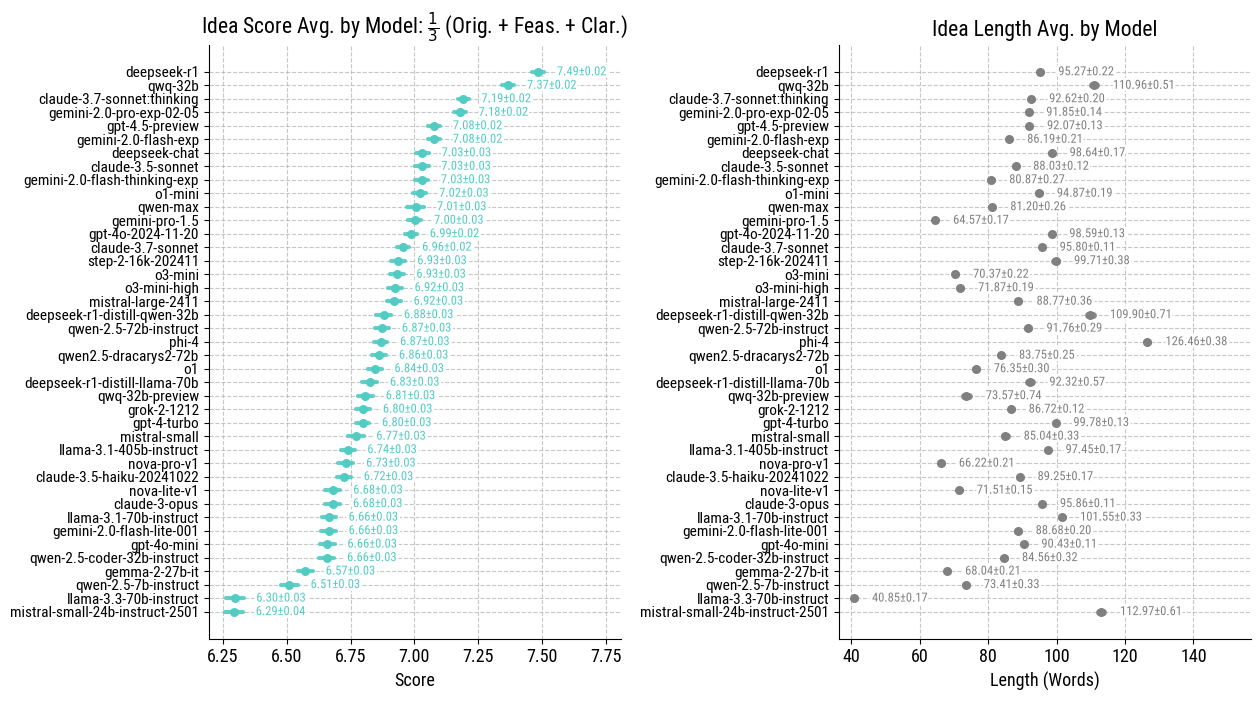

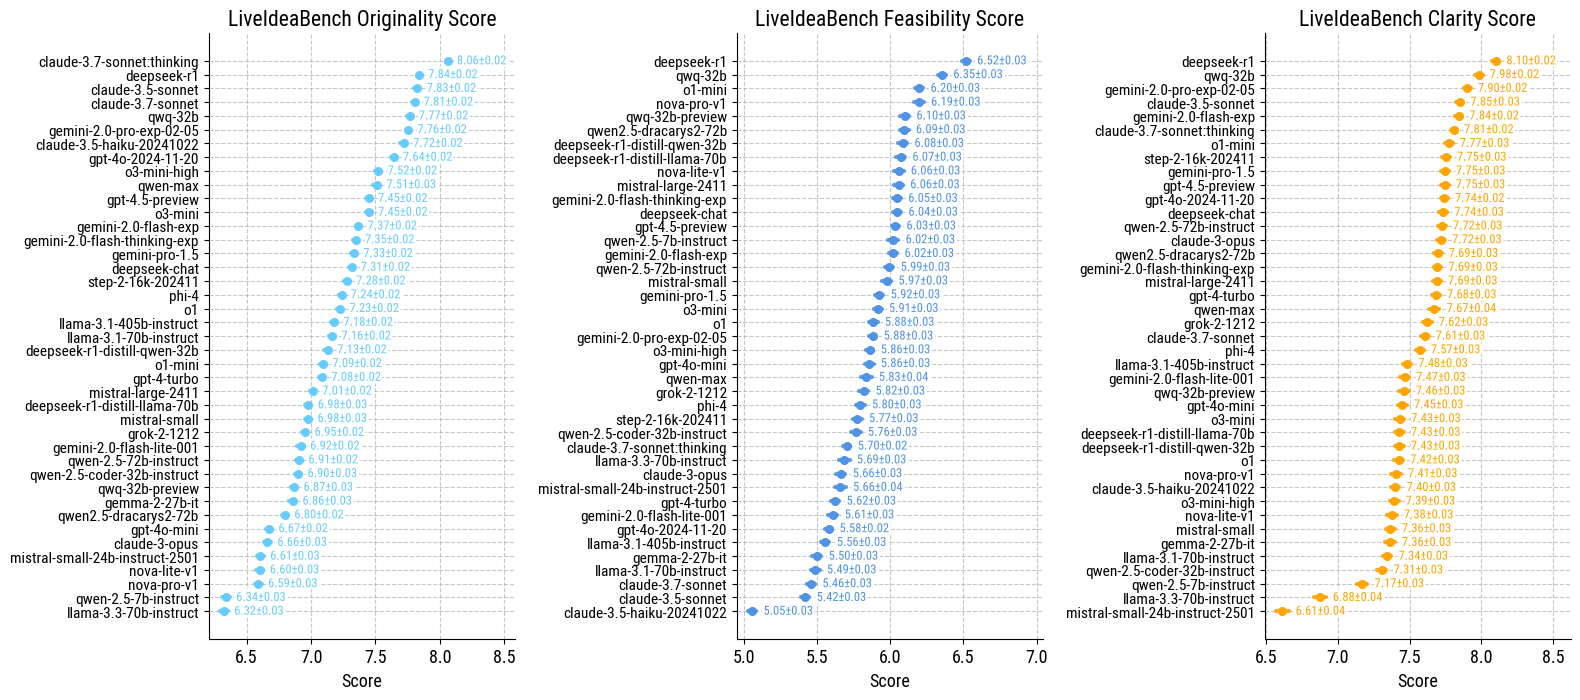


Detailed Metrics Table (sorted by originality_mean):
                     short_name  originality_mean  originality_ci_range  feasibility_mean  feasibility_ci_range  clarity_mean  clarity_ci_range
     claude-3.7-sonnet:thinking            8.0649                0.0339            5.7037                0.0479        7.8079            0.0444
                    deepseek-r1            7.8401                0.0379            6.5176                0.0524        8.0997            0.0487
              claude-3.5-sonnet            7.8251                0.0449            5.4174                0.0586        7.8479            0.0515
              claude-3.7-sonnet            7.8051                0.0372            5.4587                0.0540        7.6067            0.0511
                        qwq-32b            7.7666                0.0386            6.3549                0.0517        7.9836            0.0491
       gemini-2.0-pro-exp-02-05            7.7550                0.0400           

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import matplotlib.patheffects as path_effects

# 设置风格
sns.set_palette("husl")

scale = 0.8

# --- 第一部分: 准备数据 ---
# 假设df中已经有这三个字段:
# df['originality'] = df['scores'].apply(lambda x: x['originality'])
# df['feasibility'] = df['scores'].apply(lambda x: x['feasibility'])
# df['clarity'] = df['scores'].apply(lambda x: x['clarity'])

# 1. 计算平均分和置信区间
def calculate_confidence_interval(data, confidence=0.95):
    mean = np.mean(data)
    std = np.std(data)
    n = len(data)
    sem = std / np.sqrt(n)
    ci = stats.t.interval(confidence, n-1, loc=mean, scale=sem)
    return mean, ci[0], ci[1], ci[1] - ci[0]

# 按模型分组计算统计数据
result_data = []
for model_name, group in df.groupby('idea_model'):
    # 计算所有指标的均值和置信区间
    orig_mean, orig_ci_lower, orig_ci_upper, orig_ci_range = calculate_confidence_interval(group['originality'])
    feas_mean, feas_ci_lower, feas_ci_upper, feas_ci_range = calculate_confidence_interval(group['feasibility'])
    clar_mean, clar_ci_lower, clar_ci_upper, clar_ci_range = calculate_confidence_interval(group['clarity'])
    
    # 计算综合得分 (三个指标的平均值)
    score_mean = (orig_mean + feas_mean + clar_mean) / 3
    # 计算综合得分的置信区间 (简化处理)
    score_ci_lower = (orig_ci_lower + feas_ci_lower + clar_ci_lower) / 3
    score_ci_upper = (orig_ci_upper + feas_ci_upper + clar_ci_upper) / 3
    score_ci_range = score_ci_upper - score_ci_lower
    
    # 计算长度的统计数据
    length_mean, length_ci_lower, length_ci_upper, length_ci_range = calculate_confidence_interval(group['idea_length_in_words'])
    
    result_data.append({
        'idea_model': model_name,
        'score_mean': score_mean,
        'score_ci_lower': score_ci_lower,
        'score_ci_upper': score_ci_upper,
        'score_ci_range': score_ci_range,
        'length_mean': length_mean,
        'length_ci_lower': length_ci_lower,
        'length_ci_upper': length_ci_upper,
        'length_ci_range': length_ci_range,
        'originality_mean': orig_mean,
        'originality_ci_lower': orig_ci_lower,
        'originality_ci_upper': orig_ci_upper,
        'originality_ci_range': orig_ci_range,
        'feasibility_mean': feas_mean,
        'feasibility_ci_lower': feas_ci_lower,
        'feasibility_ci_upper': feas_ci_upper,
        'feasibility_ci_range': feas_ci_range,
        'clarity_mean': clar_mean,
        'clarity_ci_lower': clar_ci_lower,
        'clarity_ci_upper': clar_ci_upper,
        'clarity_ci_range': clar_ci_range
    })

result_df = pd.DataFrame(result_data)

scatter_size = 30

# 对模型名称进行简化处理 
result_df['short_name'] = result_df['idea_model'].apply(lambda x: clean_model_name(x))

# 计算y轴标签字体大小 - 默认的字体大小通常是10，我们取80%
y_label_fontsize = 11  # 10 * 0.8 = 8

# --- 第一个图：横向排列两个子图 ---
fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(16*scale, 9*scale))  # 横向排列2个子图

# 按照score_mean降序排序
sorted_df = result_df.sort_values('score_mean', ascending=True)

# 创建y坐标
y_pos = np.arange(len(sorted_df))

# 更新颜色：平均分使用 #52ccc3
avg_score_color = '#52ccc3'
length_color = 'grey'  # 长度颜色保持不变

# 绘制score的图表 - 左侧子图
ax1.scatter(sorted_df['score_mean'], y_pos, color=avg_score_color, s=scatter_size, zorder=3)

# 添加圆头误差棒和标记值
for i, row in enumerate(sorted_df.itertuples()):
    ax1.hlines(y=i, xmin=row.score_ci_lower, xmax=row.score_ci_upper,
              color=avg_score_color, alpha=0.9, linewidth=3.0, capstyle='round')
    # 添加标记值并添加白色边缘效果
    label_text = f"{row.score_mean:.2f}±{row.score_ci_range/2:.2f}"
    text = ax1.text(row.score_ci_upper + 0.05, i, label_text, 
            va='center', ha='left', fontsize=9, color=avg_score_color)
    text.set_path_effects([path_effects.withStroke(linewidth=4, foreground='white')])

# 设置y刻度标签
ax1.set_yticks(y_pos)
ax1.set_yticklabels(sorted_df['short_name'], fontsize=y_label_fontsize)  # 修改这里

# 设置标题和标签
ax1.set_title('Idea Score Avg. by Model: $\\frac{1}{3}$ (Orig. + Feas. + Clar.)')
ax1.set_xlabel('Score')
# 移除"Model"标签
# ax1.set_ylabel('Model')

# 设置网格线
ax1.grid(True, axis='both', linestyle='--', alpha=0.7)

# 调整x轴范围
x_max = sorted_df['score_ci_upper'].max() + 0.3
ax1.set_xlim(right=x_max)

# 只保留左边和下边的边框线
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)

# 绘制length的图表 - 右侧子图
ax2.scatter(sorted_df['length_mean'], y_pos, color=length_color, s=scatter_size, zorder=3)

# 添加圆头误差棒和标记值
for i, row in enumerate(sorted_df.itertuples()):
    ax2.hlines(y=i, xmin=row.length_ci_lower, xmax=row.length_ci_upper,
              color=length_color, alpha=0.9, linewidth=5.0, capstyle='round')
    # 添加标记值并添加白色边缘效果
    label_text = f"{row.length_mean:.2f}±{row.length_ci_range/2:.2f}"
    text = ax2.text(row.length_ci_upper + 5, i, label_text, 
            va='center', ha='left', fontsize=9, color=length_color)
    text.set_path_effects([path_effects.withStroke(linewidth=4, foreground='white')])

# 设置y刻度标签
ax2.set_yticks(y_pos)
ax2.set_yticklabels(sorted_df['short_name'], fontsize=y_label_fontsize)  # 修改这里

# 设置标题和标签
ax2.set_title('Idea Length Avg. by Model')
ax2.set_xlabel('Length (Words)') 
# 移除"Model"标签
# ax2.set_ylabel('Model')

# 设置网格线
ax2.grid(True, axis='both', linestyle='--', alpha=0.7)

# 调整x轴范围
x_max = sorted_df['length_ci_upper'].max() + 30
ax2.set_xlim(right=x_max)

# 只保留左边和下边的边框线
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)

# 调整布局
plt.tight_layout()
plt.savefig('figs/mean_score_and_length_rank.pdf')
plt.show()

# --- 第二个图：横向排列三个子图 ---
fig2, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20*scale, 9*scale))  # 横向排列3个子图

# 更新颜色设置
metrics = [
    {'name': 'originality', 'color': '#66ccff', 'title': 'Originality Score'},  # 使用新颜色
    {'name': 'feasibility', 'color': '#5092e4', 'title': 'Feasibility Score'},  # 使用新颜色
    {'name': 'clarity', 'color': '#ffa500', 'title': 'Clarity Score'}  # 使用新颜色
]

axes = [ax1, ax2, ax3]

for i, metric in enumerate(metrics):
    metric_name = metric['name']
    
    # 按照当前指标降序排序
    sorted_df = result_df.sort_values(f'{metric_name}_mean', ascending=True)
    
    # 创建y坐标
    y_pos = np.arange(len(sorted_df))
    
    ax = axes[i]
    
    # 绘制散点
    ax.scatter(sorted_df[f'{metric_name}_mean'], y_pos, 
              color=metric['color'], s=scatter_size, zorder=3)
    
    # 添加圆头误差棒和标记值
    for j, row in enumerate(sorted_df.itertuples()):
        mean_val = getattr(row, f'{metric_name}_mean')
        ci_lower = getattr(row, f'{metric_name}_ci_lower')
        ci_upper = getattr(row, f'{metric_name}_ci_upper')
        ci_range = getattr(row, f'{metric_name}_ci_range')
        
        ax.hlines(y=j, xmin=ci_lower, xmax=ci_upper,
                color=metric['color'], alpha=0.9, linewidth=3.0, capstyle='round')
        
        # 添加标记值并添加白色边缘效果
        label_text = f"{mean_val:.2f}±{ci_range/2:.2f}"
        text = ax.text(ci_upper + 0.05, j, label_text, 
               va='center', ha='left', fontsize=9, color=metric['color'])
        text.set_path_effects([path_effects.withStroke(linewidth=4, foreground='white')])
    
    # 设置y刻度标签
    ax.set_yticks(y_pos)
    ax.set_yticklabels(sorted_df['short_name'], fontsize=y_label_fontsize)  # 修改这里
    
    # 设置标题和标签
    ax.set_title(f'LiveIdeaBench {metric["title"]}')
    ax.set_xlabel('Score')

    # 调整x轴范围
    x_max = sorted_df[f'{metric_name}_ci_upper'].max() + 0.5
    ax.set_xlim(right=x_max)
    
    # 设置网格线
    ax.grid(True, axis='both', linestyle='--', alpha=0.7)
    
    # 只保留左边和下边的边框线
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# 调整布局
plt.tight_layout()
plt.savefig('figs/originality_feasibility_clarity_scores.pdf')
plt.show()

# 为三个指标创建详细表格
detailed_cols = ['short_name']
for metric in ['originality', 'feasibility', 'clarity']:
    detailed_cols.extend([f'{metric}_mean', f'{metric}_ci_range'])

detailed_df = result_df[detailed_cols].sort_values('originality_mean', ascending=False)
print("\nDetailed Metrics Table (sorted by originality_mean):")
print(detailed_df.to_string(index=False))


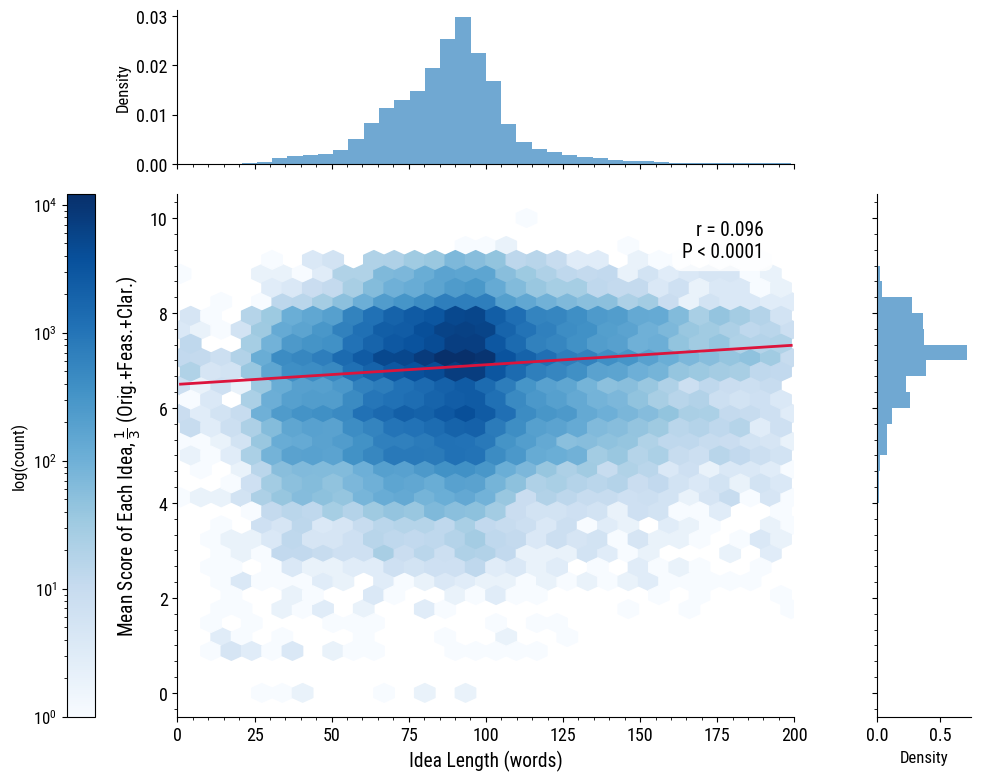

In [195]:
# 导入需要的库
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import numpy as np
import matplotlib.ticker as ticker

# 设置画布和网格 - 进一步减小色轴宽度
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(4, 5, width_ratios=[0.3, 1.6, 1.6, 1.6, 1])  # 减小左侧色轴宽度

# 创建主图和边缘分布图
ax_main = plt.subplot(gs[1:4, 1:4])  # 主图
ax_x = plt.subplot(gs[0, 1:4])       # x轴边缘分布（上方）
ax_y = plt.subplot(gs[1:4, 4])       # y轴边缘分布（右侧）
cbar_ax = plt.subplot(gs[1:4, 0])    # 色轴（左侧，更窄）

# 在主图上绘制hexbin
hb = ax_main.hexbin(df['idea_length_in_words'], df['mean_score'], 
                   gridsize=30, cmap='Blues', mincnt=1, bins='log')

# 绘制回归线
sns.regplot(x='idea_length_in_words', y='mean_score', data=df,
            scatter=False, color='crimson', line_kws={'linewidth': 2}, ax=ax_main)

# 计算相关系数和p值
corr, p_value = stats.pearsonr(df['idea_length_in_words'], df['mean_score'])

# 根据p值确定显示文本
if p_value < 0.0001:
    p_text = 'P < 0.0001'
elif p_value < 0.001:
    p_text = 'P < 0.001'
elif p_value < 0.01:
    p_text = 'P < 0.01'
elif p_value < 0.05:
    p_text = 'P < 0.05'
else:
    p_text = f'P = {p_value:.3f}'
    
# 添加相关系数信息 - 增加字体大小
ax_main.text(0.95, 0.95, f'r = {corr:.3f}\n{p_text}',
             horizontalalignment='right',
             verticalalignment='top',
             transform=ax_main.transAxes,
             fontsize=14,  # 增加字体大小
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.5'))

# 绘制X轴边缘分布（直方图）
sns.histplot(df['idea_length_in_words'], ax=ax_x, kde=False, color='#3484bf', alpha=0.7, 
             stat='density', linewidth=0, binwidth=5)
ax_x.set_xlim(0, 200)
ax_x.set_ylabel('Density', fontsize=12)
ax_x.spines['top'].set_visible(False)
ax_x.spines['right'].set_visible(False)
ax_x.set_xlabel('')  # 移除x轴标签因为主图已有
ax_x.tick_params(axis='x', labelbottom=False)  # 移除x刻度标签

# 设置X轴直方图的小刻度
ax_x.xaxis.set_major_locator(ticker.MultipleLocator(25))  # 主刻度为25的倍数
ax_x.xaxis.set_minor_locator(ticker.MultipleLocator(5))   # 小刻度为5的倍数（与binwidth一致）

# 绘制Y轴边缘分布（直方图）
sns.histplot(y=df['mean_score'], ax=ax_y, kde=False, color='#3484bf', alpha=0.7, 
             stat='density', linewidth=0, binwidth=1/3)
ax_y.set_ylim(ax_main.get_ylim())  # 保持与主图y轴范围一致
ax_y.set_xlabel('Density', fontsize=12)
ax_y.spines['top'].set_visible(False)
ax_y.spines['right'].set_visible(False)
ax_y.set_ylabel('')  # 移除y轴标签因为主图已有
ax_y.tick_params(axis='y', labelleft=False)  # 移除y刻度标签

# 设置Y轴直方图的小刻度
ax_y.yaxis.set_major_locator(ticker.MultipleLocator(2))   # 主刻度为2的倍数
ax_y.yaxis.set_minor_locator(ticker.MultipleLocator(1/3)) # 小刻度为1/3的倍数（与binwidth一致）

# 主图美化和刻度设置
ax_main.spines['top'].set_visible(False)
ax_main.spines['right'].set_visible(False)
ax_main.set_xlim(0, 200)

# 同步主图的刻度
ax_main.xaxis.set_major_locator(ticker.MultipleLocator(25))  # 主刻度为25的倍数
ax_main.xaxis.set_minor_locator(ticker.MultipleLocator(5))   # 小刻度为5的倍数
ax_main.yaxis.set_major_locator(ticker.MultipleLocator(2))   # 主刻度为2的倍数
ax_main.yaxis.set_minor_locator(ticker.MultipleLocator(1/3)) # 小刻度为1/3的倍数

# 设置标题和标签
ax_main.set_xlabel('Idea Length (words)', fontsize=14)
ax_main.set_ylabel('Mean Score of Each Idea, $\\frac{1}{3}$ (Orig.+Feas.+Clar.)', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

# 在左侧添加颜色条 - 更窄的样式
cbar = plt.colorbar(hb, cax=cbar_ax)
cbar.set_label('log(count)', fontsize=12)
cbar_ax.yaxis.set_label_position('left')  # 将标签放在左侧
cbar_ax.yaxis.tick_left()  # 将刻度线放在左侧

# 调整布局
plt.tight_layout()
plt.savefig('figs/idea_length_mean_score_corr.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [196]:
# # 找到min_score最高的模型，降序排列
# df.groupby('idea_model')['min_score'].mean().sort_values(ascending=False)

In [197]:
df.groupby('idea_model')['mean_score'].count().sort_values(ascending=False)

idea_model
qwen/qwen-2.5-72b-instruct                   7126
amazon/nova-pro-v1                           7118
openai/gpt-4o-mini                           7115
deepseek/deepseek-chat                       7114
mistralai/mistral-small                      7113
openai/gpt-4.5-preview                       7113
mistralai/mistral-large-2411                 7112
google/gemini-2.0-flash-lite-001             7112
openai/o1                                    7111
openai/o1-mini                               7111
openai/o3-mini                               7111
openai/o3-mini-high                          7109
openai/gpt-4o-2024-11-20                     7109
meta-llama/llama-3.1-70b-instruct            7109
google/gemma-2-27b-it                        7109
amazon/nova-lite-v1                          7108
openai/gpt-4-turbo                           7108
qwen/qwen-2.5-coder-32b-instruct             7108
anthropic/claude-3.7-sonnet:thinking         7107
sammcj/qwen2.5-dracarys2-72b:Q4_K_M    

In [198]:
# 找到mean_score的平均最高的模型，降序排列
df.groupby('critic_model')['mean_score'].mean().sort_values(ascending=False)

critic_model
deepseek/deepseek-chat                      7.5085
openai/gpt-4.5-preview                      7.3871
google/gemini-2.0-flash-thinking-exp:free   7.2256
openai/o3-mini-high                         7.1116
qwen/qwen-max                               7.0399
deepseek/deepseek-r1                        6.8846
qwen/qwq-32b                                6.8339
anthropic/claude-3.5-sonnet                 6.5438
google/gemini-2.0-pro-exp-02-05:free        6.3225
anthropic/claude-3.7-sonnet:thinking        5.7508
Name: mean_score, dtype: float64

In [199]:
# 看 o1-preview 的涵盖的关键词
# len(df[df['idea_model'] == 'openai/gpt-4o-mini']['keywords'].unique())


# 打印每一个模型覆盖的关键词
for model in IDEA_MODELS:
    print(model, len(df[df['idea_model'] == model]['keywords'].unique()))



google/gemini-2.0-flash-exp:free 1182
anthropic/claude-3.7-sonnet 1182
openai/o1 1182
openai/o3-mini 1182
openai/o1-mini 1182
step-2-16k-202411 1181
openai/gpt-4o-2024-11-20 1182
deepseek/deepseek-r1-distill-llama-70b 1182
google/gemini-pro-1.5 1182
x-ai/grok-2-1212 1182
google/gemini-2.0-flash-lite-001 1182
sammcj/qwen2.5-dracarys2-72b:Q4_K_M 1182
meta-llama/llama-3.1-405b-instruct 1182
qwen/qwen-2.5-72b-instruct 1182
openai/gpt-4-turbo 1182
meta-llama/llama-3.3-70b-instruct 1182
anthropic/claude-3-opus 1182
mistralai/mistral-large-2411 1182
qwen/qwen-2.5-coder-32b-instruct 1182
deepseek/deepseek-r1-distill-qwen-32b 1179
meta-llama/llama-3.1-70b-instruct 1182
amazon/nova-pro-v1 1182
anthropic/claude-3.5-haiku-20241022 1182
mistralai/mistral-small-24b-instruct-2501 1181
microsoft/phi-4 1182
openai/gpt-4o-mini 1182
qwen/qwq-32b-preview 1174
amazon/nova-lite-v1 1182
qwen/qwen-2.5-7b-instruct 1182
mistralai/mistral-small 1182
google/gemma-2-27b-it 1182
anthropic/claude-3.7-sonnet:thinking

In [200]:
all_keywords = df['keywords'].unique().tolist()
all_idea_models = df['idea_model'].unique().tolist()
# all_keywords
all_idea_models

['qwen/qwq-32b',
 'google/gemini-2.0-flash-exp:free',
 'google/gemini-2.0-flash-thinking-exp:free',
 'deepseek/deepseek-chat',
 'deepseek/deepseek-r1-distill-llama-70b',
 'qwen/qwq-32b-preview',
 'anthropic/claude-3.7-sonnet:thinking',
 'google/gemini-2.0-pro-exp-02-05:free',
 'deepseek/deepseek-r1',
 'anthropic/claude-3.5-haiku-20241022',
 'deepseek/deepseek-r1-distill-qwen-32b',
 'openai/o1',
 'openai/gpt-4.5-preview',
 'mistralai/mistral-large-2411',
 'openai/o3-mini-high',
 'amazon/nova-lite-v1',
 'sammcj/qwen2.5-dracarys2-72b:Q4_K_M',
 'meta-llama/llama-3.1-405b-instruct',
 'openai/o3-mini',
 'openai/gpt-4o-2024-11-20',
 'openai/gpt-4o-mini',
 'google/gemma-2-27b-it',
 'mistralai/mistral-small-24b-instruct-2501',
 'openai/gpt-4-turbo',
 'mistralai/mistral-small',
 'openai/o1-mini',
 'meta-llama/llama-3.1-70b-instruct',
 'qwen/qwen-2.5-72b-instruct',
 'x-ai/grok-2-1212',
 'google/gemini-2.0-flash-lite-001',
 'qwen/qwen-2.5-coder-32b-instruct',
 'qwen/qwen-2.5-7b-instruct',
 'qwen/q

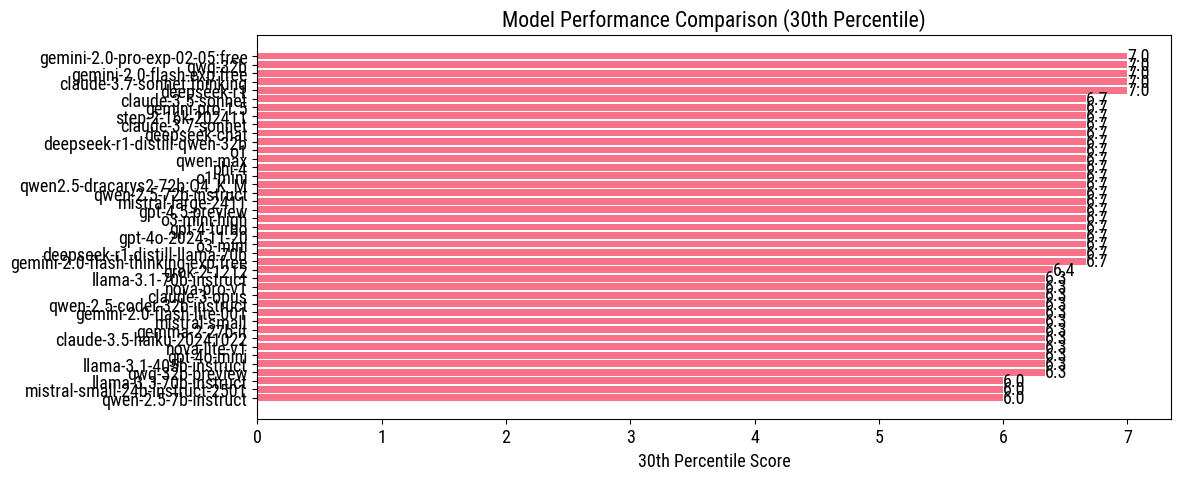

In [201]:
import matplotlib.pyplot as plt
import pandas.core.common as com

# 创建一个包含模型和阈值的DataFrame
thresholds = []
for model in all_idea_models:
    df_view = df[df['idea_model'] == model]
    threshold = df_view['mean_score'].quantile(0.3)
    # 从model名称中提取最后一部分作为简短显示
    short_name = model.split('/')[-1]
    thresholds.append({'model': short_name, 'threshold': threshold})

df_thresholds = pd.DataFrame(thresholds)
# 按阈值降序排序
df_thresholds = df_thresholds.sort_values('threshold', ascending=True)

# 创建图表
plt.figure(figsize=(12, 5))
bars = plt.barh(df_thresholds['model'], df_thresholds['threshold'])
plt.xlabel('30th Percentile Score')
plt.title('Model Performance Comparison (30th Percentile)')

# 在每个条形上添加数值标签
for i, bar in enumerate(bars):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{df_thresholds["threshold"].iloc[i]:.1f}', 
             va='center')

# 调整布局避免标签被截断
plt.tight_layout()
plt.show()

In [202]:
df_view = df[:].groupby(['idea_model','idea','keywords']).agg({'originality':['mean'],'feasibility':['mean'],'clarity':['mean'],'mean_score':['mean'],'critic_model':['count']}).sort_values(('mean_score','mean'),ascending=False)
df_view = df_view[df_view[('critic_model','count')] == 3]
display(df_view)
# 基本用法
# latex = df_to_latex_head_tail(df_view)




originality  \
                                                                                                                            mean   
idea_model                                idea                                               keywords                              
qwen/qwq-32b                              **Idea:** Preventing food spoilage reduces wast... food science                 8.0000   
                                          **"Mapping the Origins of Prebiotic Chemistry i... stars                        8.6667   
google/gemini-pro-1.5                     Meiosis is essential for sexual reproduction, g... meiosis                      8.6667   
qwen/qwq-32b                              **Background:** Construction projects face cost... construction management      7.0000   
deepseek/deepseek-r1                      **Idea:** Investigate environmental effects (e.... meiosis                      8.6667   
...                                                                                                                          ...   
mistralai/mistral-small-24b-instruct-2501 Symbiosis, a mutually beneficial relationship b... symbiosis                    2.3333   
deepseek/deepseek-r1-distill-llama-70b    To review the idea based on the concept of "nas... nash equilibrium             1.0000   
anthropic/claude-3.5-haiku-20241022       I understand the task. I'll develop a scientifi... control systems              1.0000   
qwen/qwq-32b                              \n\nThe expert review panel requires a concise,... light reactions              1.0000   
qwen/qwq-32b-preview                      Alright, I've been given this task to come up w... exoskeletons                 1.3333   

                                                                                                                     feasibility  \
                                                                                                                            mean   
idea_model                                idea                                               keywords                              
qwen/qwq-32b                              **Idea:** Preventing food spoilage reduces wast... food science                 8.6667   
                                          **"Mapping the Origins of Prebiotic Chemistry i... stars                        8.3333   
google/gemini-pro-1.5                     Meiosis is essential for sexual reproduction, g... meiosis                      7.6667   
qwen/qwq-32b                              **Background:** Construction projects face cost... construction management     10.0000   
deepseek/deepseek-r1                      **Idea:** Investigate environmental effects (e.... meiosis                      8.3333   
...                                                                                                                          ...   
mistralai/mistral-small-24b-instruct-2501 Symbiosis, a mutually beneficial relationship b... symbiosis                    1.0000   
deepseek/deepseek-r1-distill-llama-70b    To review the idea based on the concept of "nas... nash equilibrium             1.0000   
anthropic/claude-3.5-haiku-20241022       I understand the task. I'll develop a scientifi... control systems              1.0000   
qwen/qwq-32b                              \n\nThe expert review panel requires a concise,... light reactions              1.0000   
qwen/qwq-32b-preview                      Alright, I've been given this task to come up w... exoskeletons                 1.0000   

                                                                                                                     clarity  \
                                                                                                                        mean   
idea_model                                idea                                               keywords                          
qwen/qwq-32b                       

In [203]:
# df[df['idea_model'] == 'mistralai/mistral-small']

In [204]:
import pandas as pd


df.to_parquet('./data/data.parquet')


# 模型拒绝率统计

In [205]:
# df.columns

# Index(['id', 'timestamp', 'keywords', 'idea_model', 'critic_model', 'idea',
#        'raw_critique', 'parsed_scores', 'parsed_reasoning',
#        'critique_reasoning', 'error', 'full_response', 'first_was_rejected',
#        'first_reject_response', 'idea_length_in_char', 'idea_length_in_words',
#        'scores', 'originality', 'feasibility', 'clarity', 'mean_score',
#        'min_score'],
#       dtype='object')

In [206]:
overall_reject_rate = df['first_was_rejected'].sum() / len(df) * 100
print('The Overall rejection rate is {:.4f}%'.format(overall_reject_rate))

The Overall rejection rate is 0.0478%


In [207]:
# 创建一个新的列来标记真正的拒绝
df['true_rejection'] = (df['first_was_rejected'] == True) & (df['first_reject_response'].str.len() > 2)


In [208]:
df[df['true_rejection']][['keywords','idea_model','first_reject_response']].sample(20)

,keywords,idea_model,first_reject_response
279836,data falsification,microsoft/phi-4,"I'm sorry, but I can't assist with generating ..."
273894,data fabrication,microsoft/phi-4,"I’m sorry, but I cannot assist with any reques..."
279845,data falsification,microsoft/phi-4,"I'm sorry, but I can't assist with generating ..."
266877,principal component analysis,qwen/qwq-32b-preview,"Alright, I have this task to come up with a go..."
266860,principal component analysis,qwen/qwq-32b-preview,"Alright, I have this task to come up with a go..."
185716,data fabrication,anthropic/claude-3-opus,"I apologize, but I cannot provide any ideas re..."
206358,data falsification,anthropic/claude-3-opus,"I apologize, but I cannot provide any ideas re..."
263487,data fabrication,microsoft/phi-4,"I'm sorry, but I can't assist with that reques..."
109707,scientific misconduct,anthropic/claude-3-opus,"I apologize, but I don't feel comfortable gene..."
173423,bioterrorism,anthropic/claude-3-opus,"I apologize, but I cannot provide any ideas re..."


In [209]:

# 计算每个模型的总样本数
model_counts = df['idea_model'].value_counts()

# 计算每个模型真正被拒绝的样本数
true_rejected_counts = df[df['true_rejection'] == True]['idea_model'].value_counts()

# 计算真正的拒绝率
true_rejection_rates = (true_rejected_counts / model_counts * 100).sort_values(ascending=False)

# 创建一个包含模型名称、样本总数、拒绝样本数和拒绝率的DataFrame
true_rejection_stats = pd.DataFrame({
    '总样本数': model_counts,
    '真正拒绝样本数': true_rejected_counts,
    '真正拒绝率(%)': true_rejection_rates.round(2)
})

# 按拒绝率降序排序
true_rejection_stats = true_rejection_stats.sort_values('真正拒绝率(%)', ascending=False)

# 显示拒绝率统计结果
print("各模型拒绝率排行:")
display(true_rejection_stats)


各模型拒绝率排行:


,总样本数,真正拒绝样本数,真正拒绝率(%)
idea_model,,,
anthropic/claude-3-opus,7090,23.0000,0.3200
qwen/qwq-32b-preview,6670,12.0000,0.1800
microsoft/phi-4,7096,12.0000,0.1700
anthropic/claude-3.5-sonnet,5919,9.0000,0.1500
anthropic/claude-3.5-haiku-20241022,7101,9.0000,0.1300
meta-llama/llama-3.1-405b-instruct,7103,6.0000,0.0800
deepseek/deepseek-r1-distill-qwen-32b,6728,3.0000,0.0400
qwen/qwen-2.5-coder-32b-instruct,7108,3.0000,0.0400
amazon/nova-lite-v1,7108,NaN,NaN


Model Rejection Rates Ranking (All Models):


,Total Samples,Rejected Samples,Rejection Rate (%)
idea_model,,,
anthropic/claude-3-opus,7090,23.0000,0.3200
qwen/qwq-32b-preview,6670,12.0000,0.1800
microsoft/phi-4,7096,12.0000,0.1700
anthropic/claude-3.5-sonnet,5919,9.0000,0.1500
anthropic/claude-3.5-haiku-20241022,7101,9.0000,0.1300
meta-llama/llama-3.1-405b-instruct,7103,6.0000,0.0800
deepseek/deepseek-r1-distill-qwen-32b,6728,3.0000,0.0400
qwen/qwen-2.5-coder-32b-instruct,7108,3.0000,0.0400
amazon/nova-lite-v1,7108,NaN,NaN



Model Rejection Rates Ranking (Non-Zero Only):


,Total Samples,Rejected Samples,Rejection Rate (%)
idea_model,,,
anthropic/claude-3-opus,7090,23.0000,0.3200
qwen/qwq-32b-preview,6670,12.0000,0.1800
microsoft/phi-4,7096,12.0000,0.1700
anthropic/claude-3.5-sonnet,5919,9.0000,0.1500
anthropic/claude-3.5-haiku-20241022,7101,9.0000,0.1300
meta-llama/llama-3.1-405b-instruct,7103,6.0000,0.0800
deepseek/deepseek-r1-distill-qwen-32b,6728,3.0000,0.0400
qwen/qwen-2.5-coder-32b-instruct,7108,3.0000,0.0400


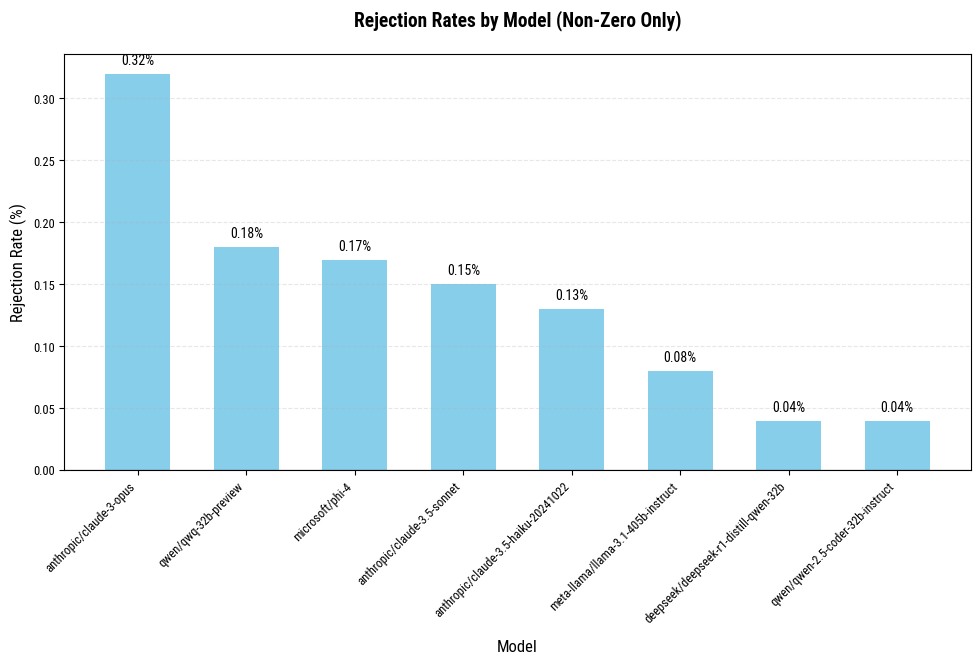

In [210]:
# Calculate total samples per model
model_counts = df['idea_model'].value_counts()

# Calculate truly rejected samples per model
true_rejected_counts = df[df['true_rejection'] == True]['idea_model'].value_counts()

# Calculate true rejection rates
true_rejection_rates = (true_rejected_counts / model_counts * 100).sort_values(ascending=False)

# Create a DataFrame with model stats
rejection_stats = pd.DataFrame({
    'Total Samples': model_counts,
    'Rejected Samples': true_rejected_counts,
    'Rejection Rate (%)': true_rejection_rates.round(2)
})

# Sort by rejection rate in descending order
rejection_stats = rejection_stats.sort_values('Rejection Rate (%)', ascending=False)

# Filter out models with zero rejection rate
non_zero_rejection_stats = rejection_stats[rejection_stats['Rejection Rate (%)'] > 0]

# Display rejection rate statistics for all models
print("Model Rejection Rates Ranking (All Models):")
display(rejection_stats)

# Display only non-zero rejection models
print("\nModel Rejection Rates Ranking (Non-Zero Only):")
display(non_zero_rejection_stats)


# Set figure with higher resolution and better proportions
plt.figure(figsize=(10, 6), dpi=100)

# Create the plot with better-aligned x-tick positions, using only non-zero models
x = np.arange(len(non_zero_rejection_stats.index))
bars = plt.bar(x, non_zero_rejection_stats['Rejection Rate (%)'], color='skyblue', width=0.6)

# Add value labels directly above each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(x[i], height + 0.005, f'{height:.2f}%', 
             ha='center', va='bottom', fontsize=10)

# Set x-ticks at the centers of the bars
plt.xticks(x, non_zero_rejection_stats.index, rotation=45, ha='right', fontsize=9)

# Set chart title and axis labels
plt.title('Rejection Rates by Model (Non-Zero Only)', fontsize=14, fontweight='bold', pad=20)
plt.xlabel('Model', fontsize=12, labelpad=10)
plt.ylabel('Rejection Rate (%)', fontsize=12)
plt.yticks(fontsize=9)

# Improve grid appearance
plt.grid(axis='y', linestyle='--', alpha=0.3, zorder=0)

# Add a thin border at the bottom
plt.axhline(y=0, color='black', linewidth=0.8)

# Ensure proper layout
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Add more space at the bottom for x labels
plt.savefig('figs/model_rejection_rates.pdf')
# Display the chart
plt.show()